# Twitter chat bot- data processing

In [ ]:
FILENAME='twitter_en.txt'a


In [121]:
EN_WHITELIST = '0123456789abcdefghijklmnopqrstuvwxyz ' # space is included in whitelist
EN_BLACKLIST = '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~\''

In [122]:
limit = {
        'maxq' : 20,
        'minq' : 0,
        'maxa' : 20,
        'mina' : 3
        }

In [123]:
UNK = 'unk'
VOCAB_SIZE = 6000

In [151]:
import random
import sys

import nltk
import itertools
from collections import defaultdict

import numpy as np

import pickle
import pandas as pd

In [125]:
def ddefault():
    return 1


 read lines from file
     return [list of lines]

In [126]:
def read_lines(filename):
    return open(filename).read().split('\n')[:-1]


split sentences in one line
  into multiple lines
    return [list of lines]

In [127]:
def split_line(line):
    return line.split('.')

remove anything that isn't in the vocabulary
    return str(pure ta/en)

In [128]:
def filter_line(line, whitelist):
    return ''.join([ ch for ch in line if ch in whitelist ])


 read list of words, create index to word,
  word to index dictionaries
    return tuple( vocab->(word, count), idx2w, w2idx )

In [129]:
def index_(tokenized_sentences, vocab_size):
    # get frequency distribution
    freq_dist = nltk.FreqDist(itertools.chain(*tokenized_sentences))
    # get vocabulary of 'vocab_size' most used words
    vocab = freq_dist.most_common(vocab_size)
    # index2word
    index2word = ['_'] + [UNK] + [ x[0] for x in vocab ]
    # word2index
    word2index = dict([(w,i) for i,w in enumerate(index2word)] )
    return index2word, word2index, freq_dist

filter too long and too short sequences
    return tuple( filtered_ta, filtered_en )

In [130]:
def filter_data(sequences):
    filtered_q, filtered_a = [], []
    raw_data_len = len(sequences)//2

    for i in range(0, len(sequences), 2):
        qlen, alen = len(sequences[i].split(' ')), len(sequences[i+1].split(' '))
        if qlen >= limit['minq'] and qlen <= limit['maxq']:
            if alen >= limit['mina'] and alen <= limit['maxa']:
                filtered_q.append(sequences[i])
                filtered_a.append(sequences[i+1])

    # print the fraction of the original data, filtered
    filt_data_len = len(filtered_q)
    filtered = int((raw_data_len - filt_data_len)*100/raw_data_len)
    print(str(filtered) + '% filtered from original data')

    return filtered_q, filtered_a

create the final dataset : 
  - convert list of items to arrays of indices
  - add zero padding
      return ( [array_en([indices]), array_ta([indices]) )

In [131]:
def zero_pad(qtokenized, atokenized, w2idx):
    # num of rows
    data_len = len(qtokenized)

    # numpy arrays to store indices
    idx_q = np.zeros([data_len, limit['maxq']], dtype=np.int32) 
    idx_a = np.zeros([data_len, limit['maxa']], dtype=np.int32)

    for i in range(data_len):
        q_indices = pad_seq(qtokenized[i], w2idx, limit['maxq'])
        a_indices = pad_seq(atokenized[i], w2idx, limit['maxa'])

        #print(len(idx_q[i]), len(q_indices))
        #print(len(idx_a[i]), len(a_indices))
        idx_q[i] = np.array(q_indices)
        idx_a[i] = np.array(a_indices)

    return idx_q, idx_a

replace words with indices in a sequence
  replace with unknown if word not in lookup
    return [list of indices]

In [132]:
def pad_seq(seq, lookup, maxlen):
    indices = []
    for word in seq:
        if word in lookup:
            indices.append(lookup[word])
        else:
            indices.append(lookup[UNK])
    return indices + [0]*(maxlen - len(seq))

In [133]:
def process_data():

    print('\n>> Read lines from file')
    lines = read_lines(filename=FILENAME)

    # change to lower case (just for en)
    lines = [ line.lower() for line in lines ]

    print('\n:: Sample from read(p) lines')
    print(lines[121:125])

    # filter out unnecessary characters
    print('\n>> Filter lines')
    lines = [ filter_line(line, EN_WHITELIST) for line in lines ]
    print(lines[121:125])

    # filter out too long or too short sequences
    print('\n>> 2nd layer of filtering')
    qlines, alines = filter_data(lines)
    print('\nq : {0} ; a : {1}'.format(qlines[60], alines[60]))
    print('\nq : {0} ; a : {1}'.format(qlines[61], alines[61]))


    # convert list of [lines of text] into list of [list of words ]
    print('\n>> Segment lines into words')
    qtokenized = [ wordlist.split(' ') for wordlist in qlines ]
    atokenized = [ wordlist.split(' ') for wordlist in alines ]
    print('\n:: Sample from segmented list of words')
    print('\nq : {0} ; a : {1}'.format(qtokenized[60], atokenized[60]))
    print('\nq : {0} ; a : {1}'.format(qtokenized[61], atokenized[61]))


    # indexing -> idx2w, w2idx : en/ta
    print('\n >> Index words')
    idx2w, w2idx, freq_dist = index_( qtokenized + atokenized, vocab_size=VOCAB_SIZE)

    print('\n >> Zero Padding')
    idx_q, idx_a = zero_pad(qtokenized, atokenized, w2idx)

    print('\n >> Save numpy arrays to disk')
    # save them
    np.save('idx_q.npy', idx_q)
    np.save('idx_a.npy', idx_a)

    # let us now save the necessary dictionaries
    metadata = {
            'w2idx' : w2idx,
            'idx2w' : idx2w,
            'limit' : limit,
            'freq_dist' : freq_dist
                }

    # write to disk : data control dictionaries
    with open('metadata.pkl', 'wb') as f:
        pickle.dump(metadata, f)

In [134]:
def load_data(PATH=''):
    # read data control dictionaries
    with open(PATH + 'metadata.pkl', 'rb') as f:
        metadata = pickle.load(f)
    # read numpy arrays
    idx_ta = np.load(PATH + 'idx_q.npy')
    idx_en = np.load(PATH + 'idx_a.npy')
    
    return metadata, idx_q, idx_a


In [135]:
if __name__ == '__main__':
    process_data()


>> Read lines from file

:: Sample from read(p) lines
['in the future our robot overlords will honor acts of heroism such as preformed by', "stop squirming. you're making it hurt worse.", 'you are a keyboard warrior champion', "it's late september, which can mean only one thing: summer has finally come to the bay area."]

>> Filter lines
['in the future our robot overlords will honor acts of heroism such as preformed by', 'stop squirming youre making it hurt worse', 'you are a keyboard warrior champion', 'its late september which can mean only one thing summer has finally come to the bay area']

>> 2nd layer of filtering
29% filtered from original data

q : betting android phones wont have headphone jokes in the next 18 months ; a : i hope youre right

q : avast ye mateys it is almost time for a perfect day fer it ; a : imagine a pirate twitter chat

>> Segment lines into words

:: Sample from segmented list of words

q : ['betting', 'android', 'phones', 'wont', 'have', 'headphone', '

In [136]:
import data
import importlib as I
I.reload(data)

<module 'data' (namespace)>

In [137]:
idx_q, idx_a, metadata =load_data('data/')

In [ ]:
df=pd.DataFrame({A:idx_q['freq_dist']})

In [139]:
from matplotlib import pyplot as plt
%matplotlib inline


In [140]:
#freq = FreqDist([tag for word, tag in X_tagged])
freq = [ freq_ for name, freq_ in idx_a['freq_dist'].most_common(10000) ]

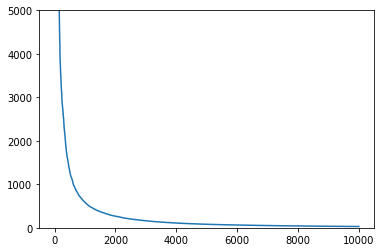

In [141]:
plt.plot(list(range(len(freq))), freq)
axes = plt.gca()
#axes.set_xlim([xmin,xmax])
axes.set_ylim([0,5000])
plt.show()

In [142]:
# number of unknowns
UNK='unk'
num_unk = (idx_a['freq_dist']['unk']) + (idx_q['freq_dist'][UNK])

In [144]:
# number of words in vocabulary (excluding zeros)
num_words = (idx_a['freq_dist'])+ (idx_q['freq_dist'])


In [ ]:
df = pd.DataFrame({'word':idx_q['freq_dist'][0],'dist':idx_q['freq_dist'][1]})

In [160]:
idx_q['freq_dist'][1]

0

In [146]:
import numpy as np
from random import sample

In [ ]:
#def split_dataset(x, y, ratio = [0.7, 0.15, 0.15] ):
    # number of examples
x=idx_q 
y=idx_a
ratio=0.7
data_len = len(x)
lens = [ int(data_len*ratio) ]

trainX, trainY = x[:lens[0]], y[:lens[0]]
testX, testY = x[lens[0]:lens[0]+lens[1]], y[lens[0]:lens[0]+lens[1]]
validX, validY = x[-lens[-1]:], y[-lens[-1]:]

#return (trainX,trainY), (testX,testY), (validX,validY)}

'''
 split data into train (70%), test (15%) and valid(15%)
    return tuple( (trainX, trainY), (testX,testY), (validX,validY) )
'''

In [119]:
x

{'freq_dist': FreqDist({'yeah': 5843,
           'im': 28754,
           'preparing': 102,
           'myself': 1540,
           'to': 128981,
           'drop': 664,
           'a': 113454,
           'lot': 2847,
           'on': 46913,
           'this': 54317,
           'man': 5604,
           'but': 29966,
           'definitely': 1871,
           'need': 8974,
           'something': 4227,
           'reliable': 72,
           'shouldnt': 789,
           'the': 174865,
           'supporters': 874,
           'natural': 197,
           'answer': 1276,
           's': 2618,
           'hashtag': 309,
           'be': 33938,
           '': 120387,
           'you': 100619,
           'want': 7782,
           'turn': 1010,
           'twitter': 3406,
           'followers': 480,
           'into': 4610,
           'blog': 399,
           'readers': 87,
           'well': 8274,
           'i': 124650,
           'finally': 1417,
           'finished': 431,
           'watching': 260

 generate batches from dataset
    yield (x_gen, y_gen)


In [101]:
def batch_gen(x, y, batch_size):
    # infinite while
    while True:
        for i in range(0, len(x), batch_size):
            if (i+1)*batch_size < len(x):
                yield x[i : (i+1)*batch_size ].T, y[i : (i+1)*batch_size ].T


 generate batches, by random sampling a bunch of items
    yield (x_gen, y_gen)


In [102]:
def rand_batch_gen(x, y, batch_size):
    while True:
        sample_idx = sample(list(np.arange(len(x))), batch_size)
        yield x[sample_idx].T, y[sample_idx].T


a generic decode function 
    inputs : sequence, lookup


In [104]:
def decode(sequence, lookup, separator=''): # 0 used for padding, is ignored
    return separator.join([ lookup[element] for element in sequence if element ])